# Deep learning project: Colorizing black and white images

## 0. Introduction
This notebook contains the code and results for the project done by Eric Johansson and Per Ljung in the course Deep machine learning (SSY340/DAT968). The main objective is to take black and white images as input and colorize them using <font color='red'>whatever we end up using</font>. <font color='green'>Further explore possibility of sequences of images.</font>

## 1. Collecting and pre-processing of data
As dataset we first use the MIT Places image database. The goal of this section is to
<ol>
  <li>Download the data from MIT Places.</li>
  <li>Split the data into training, validation and testing datasets.</li>
  <li>Provide a function that can turn a colorful image into black and white format.</li>
</ol>
We begin by importing necessary modules for the project.

In [64]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as T
from torchvision import datasets

from skimage import io, color
from skimage.color import lab2rgb, rgb2lab, rgb2gray
import seaborn as sns

import os, time, shutil, re

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 1.1 Download data from MIT Places
To begin with, we will use a subset of the dataset Places205 from <a href="http://places.csail.mit.edu">MIT Places</a>, which is an image dataset containing 2,448,873 images from 205 scene categories. Our subset contains 41,000 images. In ubuntu, this can be done immediately in the terminal by the command
```
wget http://data.csail.mit.edu/places/places205/testSetPlaces205_resize.tar.gz -P path/to/project
```
and extract it. The code below takes the images and divides them into training and validation data.

### 1.2 Split data into training and validation
The subset contains 41,000 images. We split it into a training set containing 40,000 images and a validation set with 1,000 images. 

In [18]:
# Divide data into training (40,000 images) and validation (1,000 images)
os.makedirs('images/train/train_subfolder/', exist_ok=True)
os.makedirs('images/val/val_subfolder/', exist_ok=True)
os.makedirs('images/subtrain/subtrain_subfolder/', exist_ok=True)
os.makedirs('images/subval/subval_subfolder/', exist_ok=True)
for i, file in enumerate(os.listdir('testSetPlaces205_resize/testSet_resize')):
    if i < 100:
        os.rename('testSetPlaces205_resize/testSet_resize/' + file, 'images/subval/subval_subfolder/' + file)
    elif i < 1000:
        os.rename('testSetPlaces205_resize/testSet_resize/' + file, 'images/subtrain/subtrain_subfolder/' + file)
    elif i < 2000:
        os.rename('testSetPlaces205_resize/testSet_resize/' + file, 'images/val/val_subfolder/' + file)
    else:
        os.rename('testSetPlaces205_resize/testSet_resize/' + file, 'images/train/train_subfolder/' + file)
        
        
#  if i < 1000:
#    os.rename('testSetPlaces205_resize/testSet_resize/' + file, 'images/val/val_subfolder/' + file)
#  else:
#    os.rename('testSetPlaces205_resize/testSet_resize/' + file, 'images/train/train_subfolder/' + file)

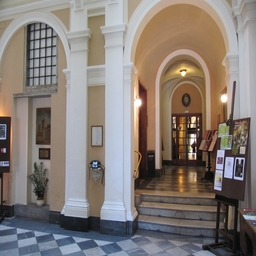

In [20]:
# Display an example image
from IPython.display import Image, display
display(Image(filename='images/val/val_subfolder/0bb654d392eccbcf2b363a273685cd81.jpg'))

### 1.3 Construct network for colorization
We now define the network to train. <font color='red'>Description of what we use in the network like resnet, upsampling, etc.</font>

### 1.4 Visualization of LAB vs RGB images
To get a feel for LAB-images the below cell is dedicated for visualization of RGB and LAB images with their different channels. 
  
From wikipedia:    
The lightness value, $L$, also referred to as "Lstar," defines black at 0 and white at 100. The $a$ axis is relative to the green–red opponent colors, with negative values toward green and positive values toward red. The $b$ axis represents the blue–yellow opponents, with negative numbers toward blue and positive toward yellow.

  
<font color='red'>This cell is thought to be used in the initial states of the project, to get some intuition of the different formats and how to convert between them as well as how to produce figures from LAB-images since our network output will be in LAB format.</font>

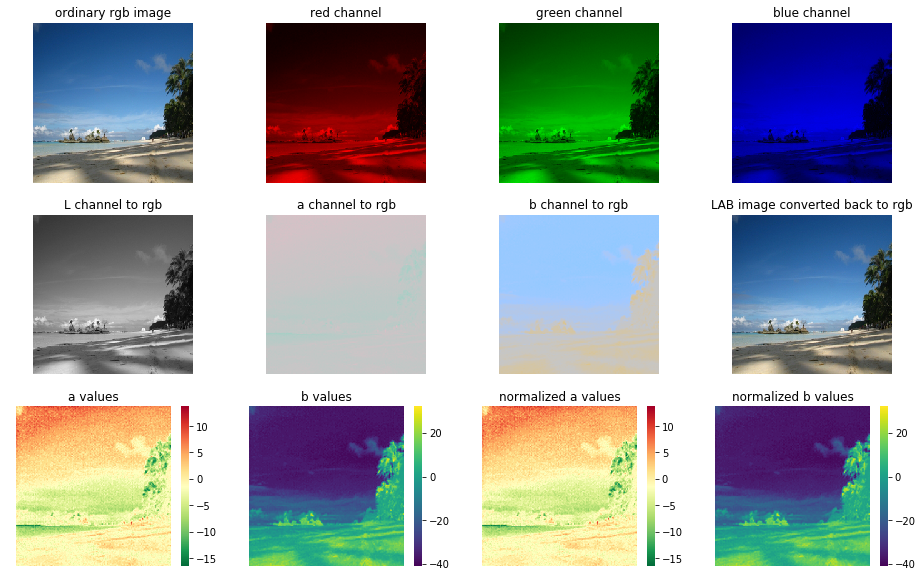

In [21]:
def get_rgb_and_lab_image(filename):
    """ Takes image filename as argument 
    
        Returns normalized rgb and lab images
    """   
    rgb = io.imread(filename)
    rgb_scaled = rgb / 255    
    lab = color.rgb2lab(rgb)
    lab_scaled = (lab + [0, 128, 128]) / [100, 255, 255]   
    return rgb_scaled, lab_scaled

def get_rgb_channel_for_plotting(image, channel):
    """ Takes an image and the desired channel as arguments.
        channel: [0, 1, 2] = [red, green, blue]
        
        Returns an image with only the desired channel activated """
    rgb_channel = np.zeros(image.shape)
    rgb_channel[:, :, channel] += image[: ,:, channel]
    return rgb_channel

def get_lab_channel_for_plotting(image, channel):
    """ Takes an image in lab format and the desired channel as arguments.
        channel: [0, 1, 2] = [Lightness, a, b]
        
        Expects the lab image to be scaled
        
        Returns an image with only the desired channel activated """
    lab_channel = np.zeros(image.shape)
    image = image * [100, 255, 255] - [0, 128, 128] # rescale
    lab_channel[:, :, channel] += image[:, :, channel]
    if channel != 0:
        lab_channel[:,:,0]+=80 # we need some light for the a and b channels to be visible
    lab_channel = color.lab2rgb(lab_channel)
    return lab_channel

def get_lab_for_plotting(image):
    """ Expects a scaled lab-image
    
        Returns the lab image converted to rgb """
    rescaled_lab = image * [100, 255, 255] - [0, 128, 128]
    rgb = color.lab2rgb(rescaled_lab)
    return rgb
    
filename = 'images/train/train_subfolder/0a56c95e047247ac4df457d5663e03fe.jpg'    
    
fig, ax = plt.subplots(3,4, figsize = (16, 10))
rgb, lab = get_rgb_and_lab_image(filename)

# Plot full rgb image
ax[0][0].imshow(rgb)
ax[0][0].set_title('ordinary rgb image')
ax[0][0].axis('off')

# Plot each channel of rgb image
for i, title in enumerate(['red channel', 'green channel', 'blue channel']):
    ax[0][i+1].imshow(get_rgb_channel_for_plotting(rgb, i))
    ax[0][i+1].set_title(title)
    ax[0][i+1].axis('off')
    
# Plot each channel of lab image
for i, title in enumerate(['L channel to rgb', 'a channel to rgb', 'b channel to rgb']):
    ax[1][i].imshow(get_lab_channel_for_plotting(lab, i))
    ax[1][i].set_title(title)
    ax[1][i].axis('off')
    
# Plot lab image converted back to rgb
ax[1][3].imshow(get_lab_for_plotting(lab))
ax[1][3].set_title('LAB image converted back to rgb')
ax[1][3].axis('off')

# Plot lab ab channels values
titles = ['a values', 'b values', 'normalized a values', 'normalized b values']
cmaps = ['RdYlGn_r', 'viridis', 'RdYlGn_r', 'viridis']
for i, (title, cm) in enumerate(zip(titles, cmaps)):
    sns.heatmap(lab[:, :, i % 2 + 1] * 255 - 128, ax = ax[2][i], cmap=cm)
    ax[2][i].set(xticks=[])
    ax[2][i].set(yticks=[])
    ax[2][i].set_title(title)


### 1.5 Create dataset  
It is convinient for us to create a custom dataset and use this to convert images to LAB format. We'll let our dataset inherit datasets.ImageFolder and override the __getitem__ method from <a href="https://github.com/pytorch/vision/blob/3e60fb29986ad74d9e4dc5715479d7bd3d8b59ba/torchvision/datasets/folder.py#L108-L144">this function</a>, such that we can use a dataloader to directly sample greyscale images (the lightness channel from LAB-images) used as input to our network and images containing only the __a__ and __b__ channels from LAB-images later used as targets to our network.  

In [38]:
class LABImageFolder(datasets.ImageFolder):
    
  """Convert images to LAB-format and output lightness channel as well as a & b channels"""

  def __getitem__(self, index):
    path, target = self.imgs[index]
    sample = self.loader(path)
    if self.transform is not None:
        rgb_image = self.transform(sample)
        lab = color.rgb2lab(rgb_image)
        lab_scaled = (lab + [0, 128, 128]) / [100, 255, 255]
        L_channel = np.zeros(lab_scaled.shape[0:2])
        L_channel += lab_scaled[:, :, 0]
        ab_channels = np.zeros(lab_scaled.shape[0:2] + (2,))
        ab_channels += lab_scaled[:, :, 1:3]
        sample_grayscale = torch.from_numpy(L_channel)
        sample_ab = torch.from_numpy(ab_channels).permute(2,0,1).float()
        sample_grayscale = torch.unsqueeze(sample_grayscale, 0).float()
    if self.target_transform is not None:
        target = self.target_transform(target)
    return sample_grayscale, sample_ab, target

img_size = 256

# Transform with data augmentation
train_transforms = T.Compose([T.RandomHorizontalFlip(), 
                             T.RandomResizedCrop(img_size, scale=(0.7,1)),
                             T.ColorJitter(brightness=0.5),
                             T.RandomRotation(degrees=20)])
# Train
#train_transforms = T.Compose([transforms.Resize(256)])
train_imagefolder = LABImageFolder('images/train/', train_transforms)
train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True)

# Validation 
val_transforms = T.Compose([transforms.Resize(256)])
val_imagefolder = LABImageFolder('images/val/' , val_transforms)
val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

# Train
subtrain_transforms = T.Compose([transforms.Resize(256)])
subtrain_imagefolder = LABImageFolder('images/subtrain/', subtrain_transforms)
subtrain_loader = torch.utils.data.DataLoader(subtrain_imagefolder, batch_size=64, shuffle=True)

# Validation 
subval_transforms = T.Compose([transforms.Resize(256)])
subval_imagefolder = LABImageFolder('images/subval/' , subval_transforms)
subval_loader = torch.utils.data.DataLoader(subval_imagefolder, batch_size=64, shuffle=False)

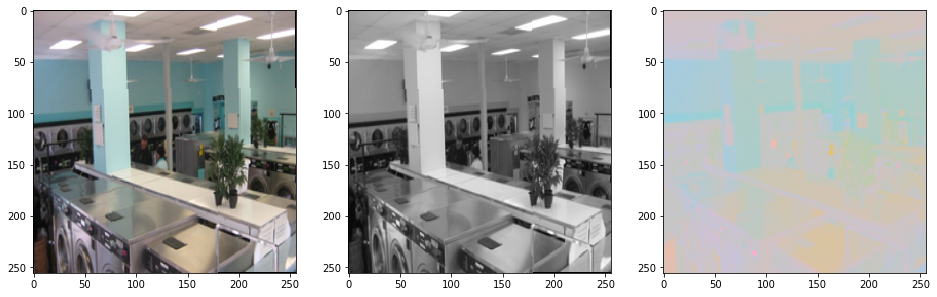

In [40]:
def plot_lab(sample_lightness, sample_ab):

    # Convert to suitable dimensions
    sample_lightness = sample_lightness.squeeze(0); sample_ab = sample_ab.permute(1,2,0)
    
    # Initialize zero tensors
    lab = torch.zeros(sample_lightness.shape + (3,))
    l = torch.zeros(sample_lightness.shape + (3,))
    ab = torch.zeros(sample_lightness.shape + (3,))
    
    # Convert lightness channel
    l[:, :, 0] += sample_lightness * 100
    l = color.lab2rgb(l)
    
    # Convert ab channel
    ab[:, :, 0] += 80
    ab[:, :, 1:3] += sample_ab * 255 - 128
    ab = color.lab2rgb(ab)
    
    # Put together full image
    lab[:, :, 0] = sample_lightness * 100
    lab[:, :, 1:3] = sample_ab * 255 - 128
    lab = color.lab2rgb(lab)
    
    # Plot full image together with lightness and ab channels
    fig, ax = plt.subplots(1, 3, figsize=(16, 10))
    ax[0].imshow(lab)
    ax[1].imshow(l)
    ax[2].imshow(ab)
    
samples_grayscale, samples_ab, _ = next(iter(train_loader))
plot_lab(samples_grayscale[0], samples_ab[0])

### Create network

In [41]:
class ColorizationNet(nn.Module):
  def __init__(self, input_size=128):
    super(ColorizationNet, self).__init__()
    MIDLEVEL_FEATURE_SIZE = 128

    ## First half: ResNet
    resnet = models.resnet18(num_classes=365) 
    # Change first conv layer to accept single-channel (grayscale) input
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
    # Extract midlevel features from ResNet-gray
    self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

    ## Second half: Upsampling
    self.upsample = nn.Sequential(     
      nn.Conv2d(MIDLEVEL_FEATURE_SIZE, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):

    # Pass input through ResNet-gray to extract features
    midlevel_features = self.midlevel_resnet(input)

    # Upsample to get colors
    output = self.upsample(midlevel_features)
    return output

In [62]:
model = ColorizationNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=0.0)
load_model = True
load_path = 'checkpoints/current_model_0.00277.pth'
if os.path.isfile(load_path) and load_model:
    print('Model loaded')
    model.load_state_dict(torch.load('checkpoints/current_model.pth'))

Model loaded


In [43]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial''' 
  def __init__(self):
    self.reset()
  def reset(self):
    self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
  '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
  plt.clf() # clear matplotlib 
  color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
  color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
  color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
  color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
  color_image = lab2rgb(color_image.astype(np.float64))
  grayscale_input = grayscale_input.squeeze().numpy()
  if save_path is not None and save_name is not None: 
    plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
    plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))


In [44]:
def validate(val_loader, model, criterion, save_images, epoch):
  model.eval()

  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  already_saved_images = False
  for i, (input_gray, input_ab, target) in enumerate(val_loader):
    data_time.update(time.time() - end)

    # Use GPU
    #if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()
    input_gray, input_ab, target = input_gray.to(device),  input_ab.to(device), target.to(device)

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
      already_saved_images = True
      for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
      print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

  print('Finished validation.')
  return losses.avg

def train(train_loader, model, criterion, optimizer, epoch):
  print('Starting training epoch {}'.format(epoch))
  model.train()
  
  # Prepare value counters and timers
  batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

  end = time.time()
  for i, (input_gray, input_ab, target) in enumerate(train_loader):
    
    # Use GPU
    #if use_gpu: input_gray, input_ab, target = input_gray.cuda(), input_ab.cuda(), target.cuda()
    input_gray, input_ab, target = input_gray.to(device),  input_ab.to(device), target.to(device)

    # Record time to load data (above)
    data_time.update(time.time() - end)

    # Run forward pass
    output_ab = model(input_gray) 
    loss = criterion(output_ab, input_ab) 
    losses.update(loss.item(), input_gray.size(0))

    # Compute gradient and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Record time to do forward and backward passes
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to value, not validation
    if i % 25 == 0:
      print('Epoch: [{0}][{1}/{2}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
              epoch, i, len(train_loader), batch_time=batch_time,
             data_time=data_time, loss=losses)) 

  print('Finished training epoch {}'.format(epoch))

In [45]:
criterion = criterion.to(device)
model = model.to(device)

In [67]:
# Make folders and set parameters
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
if load_model:
    best_losses  = float(re.search('current_model_(.+?).pth', load_path).group(1))
else:
    best_losses = 1e10
epochs = 5

In [ ]:
# Train model
for epoch in range(epochs):
  # Train for one epoch, then validate
  train(train_loader, model, criterion, optimizer, epoch)
  with torch.no_grad():
    losses = validate(val_loader, model, criterion, save_images, epoch)
  # Save checkpoint and replace old best model if current model is better
  if losses < best_losses:
    best_losses = losses
    torch.save(model.state_dict(), 'checkpoints/model-epoch-{}-losses-{:.3f}.pth'.format(epoch+1,losses))


Starting training epoch 0
Epoch: [0][0/610]	Time 8.040 (8.040)	Data 0.969 (0.969)	Loss 0.0022 (0.0022)	
Epoch: [0][25/610]	Time 7.183 (7.590)	Data 0.972 (0.958)	Loss 0.0033 (0.0050)	
Epoch: [0][50/610]	Time 7.684 (7.543)	Data 0.936 (0.963)	Loss 0.0030 (0.0040)	
Epoch: [0][75/610]	Time 6.150 (7.329)	Data 0.899 (0.952)	Loss 0.0024 (0.0036)	
Epoch: [0][100/610]	Time 6.141 (7.046)	Data 0.882 (0.937)	Loss 0.0031 (0.0034)	
Epoch: [0][125/610]	Time 6.200 (6.877)	Data 0.878 (0.927)	Loss 0.0029 (0.0032)	
Epoch: [0][150/610]	Time 6.156 (6.759)	Data 0.891 (0.920)	Loss 0.0026 (0.0031)	
Epoch: [0][175/610]	Time 6.204 (6.676)	Data 0.873 (0.915)	Loss 0.0026 (0.0031)	
Epoch: [0][200/610]	Time 6.250 (6.611)	Data 0.894 (0.911)	Loss 0.0033 (0.0030)	
Epoch: [0][225/610]	Time 6.457 (6.563)	Data 0.876 (0.907)	Loss 0.0024 (0.0030)	
Epoch: [0][250/610]	Time 6.294 (6.529)	Data 0.889 (0.905)	Loss 0.0026 (0.0029)	
Epoch: [0][275/610]	Time 6.147 (6.498)	Data 0.890 (0.903)	Loss 0.0027 (0.0029)	
Epoch: [0][300/610]

Epoch: [3][575/610]	Time 5.995 (6.120)	Data 0.859 (0.882)	Loss 0.0019 (0.0025)	
Epoch: [3][600/610]	Time 6.120 (6.118)	Data 0.905 (0.881)	Loss 0.0021 (0.0025)	
Finished training epoch 3
Validate: [0/16]	Time 2.524 (2.524)	Loss 0.0024 (0.0024)	
Finished validation.
Starting training epoch 4
Epoch: [4][0/610]	Time 6.223 (6.223)	Data 0.886 (0.886)	Loss 0.0020 (0.0020)	
Epoch: [4][25/610]	Time 6.095 (6.097)	Data 0.884 (0.879)	Loss 0.0029 (0.0024)	
Epoch: [4][50/610]	Time 5.997 (6.098)	Data 0.866 (0.882)	Loss 0.0028 (0.0025)	
Epoch: [4][75/610]	Time 6.205 (6.104)	Data 0.889 (0.881)	Loss 0.0022 (0.0025)	
Epoch: [4][100/610]	Time 5.973 (6.103)	Data 0.869 (0.880)	Loss 0.0027 (0.0025)	
Epoch: [4][125/610]	Time 6.124 (6.102)	Data 0.874 (0.879)	Loss 0.0022 (0.0025)	
Epoch: [4][150/610]	Time 6.054 (6.116)	Data 0.883 (0.878)	Loss 0.0024 (0.0025)	
Epoch: [4][175/610]	Time 6.298 (6.116)	Data 0.883 (0.879)	Loss 0.0028 (0.0025)	
Epoch: [4][200/610]	Time 6.121 (6.113)	Data 0.883 (0.879)	Loss 0.0023 (0.0

Epoch: [7][500/610]	Time 6.182 (6.206)	Data 0.905 (0.890)	Loss 0.0031 (0.0024)	
Epoch: [7][525/610]	Time 6.178 (6.207)	Data 0.903 (0.890)	Loss 0.0029 (0.0025)	
Epoch: [7][550/610]	Time 6.193 (6.210)	Data 0.914 (0.891)	Loss 0.0025 (0.0024)	
Epoch: [7][575/610]	Time 6.339 (6.213)	Data 0.897 (0.891)	Loss 0.0026 (0.0024)	
Epoch: [7][600/610]	Time 6.229 (6.215)	Data 0.917 (0.892)	Loss 0.0020 (0.0024)	
Finished training epoch 7
Validate: [0/16]	Time 2.554 (2.554)	Loss 0.0023 (0.0023)	
Finished validation.
Starting training epoch 8
Epoch: [8][0/610]	Time 6.305 (6.305)	Data 0.928 (0.928)	Loss 0.0029 (0.0029)	
Epoch: [8][25/610]	Time 6.269 (6.314)	Data 0.908 (0.903)	Loss 0.0022 (0.0025)	
Epoch: [8][50/610]	Time 6.233 (6.279)	Data 0.910 (0.901)	Loss 0.0027 (0.0025)	
Epoch: [8][75/610]	Time 6.167 (6.279)	Data 0.897 (0.900)	Loss 0.0023 (0.0025)	


In [50]:
# Validate
save_images = True
with torch.no_grad():
  validate(val_loader, model, criterion, save_images, 0)

Validate: [0/16]	Time 2.790 (2.790)	Loss 0.0024 (0.0024)	
Finished validation.


<Figure size 432x288 with 0 Axes>

In [61]:
# Save current model
torch.save(model.state_dict(), 'checkpoints/current_model_{:.5f}.pth'.format(losses))

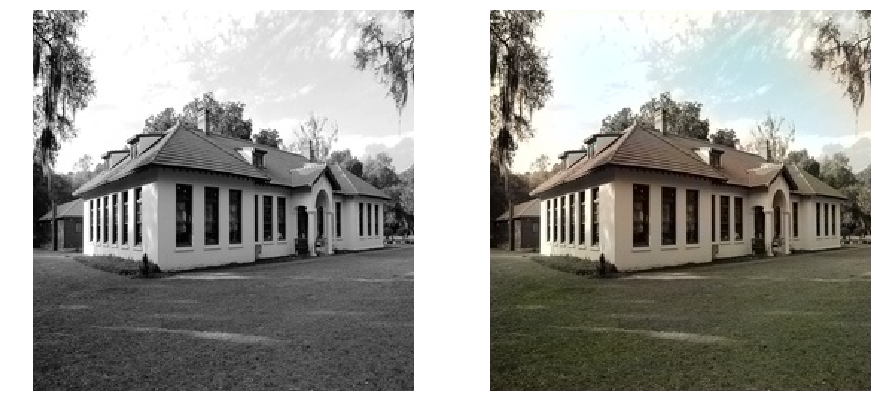

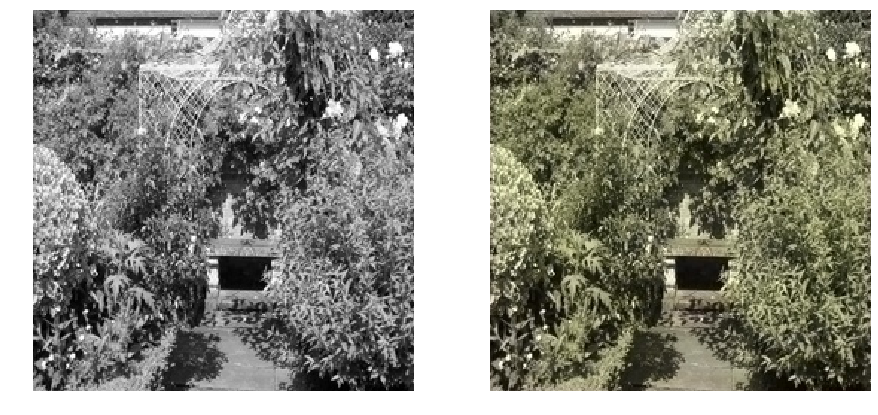

In [56]:
# Show images 
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-0-epoch-0.jpg', 'outputs/gray/img-0-epoch-0.jpg'),
               ('outputs/color/img-6-epoch-0.jpg', 'outputs/gray/img-6-epoch-0.jpg')]
for c, g in image_pairs:
  color = mpimg.imread(c)
  gray  = mpimg.imread(g)
  f, axarr = plt.subplots(1, 2)
  f.set_size_inches(15, 15)
  axarr[0].imshow(gray, cmap='gray')
  axarr[1].imshow(color)
  axarr[0].axis('off'), axarr[1].axis('off')
  plt.show()

In [59]:
print(losses)

0.0027711563166230918
